In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob as gb
import shutil
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

from tensorflow.keras.applications import VGG19

%matplotlib inline
tf.random.set_seed(0)
np.random.seed(0)

# Import Data

In [ ]:
shutil.unpack_archive('covid-19-detection-using-transfer-learning.zip')

In [2]:
train_path = 'kaggle_transfer_learning_covid/train/'
test_path = 'kaggle_transfer_learning_covid/test/'

In [3]:
size=[]
file_count = 0
for folder in os.listdir(train_path):
    files = os.listdir(train_path+folder)
    print(f'For training we have {len(files)} images in the folder {folder}')
    file_count += len(files)
    for file in files:
        img = plt.imread(train_path+folder+'/'+file)
        size.append(img.shape)
        
print(f'Total image count is: {file_count}')
print(f'{pd.Series(size).value_counts()[0]/file_count:.2%} of the files are of the same size')


For training we have 70 images in the folder covid
For training we have 70 images in the folder normal
For training we have 70 images in the folder pneumonia
Total image count is: 210
0.95% of the files are of the same size


In [4]:
size = []
file_count = len(os.listdir(test_path))
for file in os.listdir(test_path):
    size.append((plt.imread(test_path+file)).shape)
print(f'Total file count is {file_count}')
print(f'{pd.Series(size).value_counts()[0]/file_count:.2%} of the images are the same size')

Total file count is 96
1.04% of the images are the same size


In [5]:
def prepare_image(img):
    assert img.shape[0] > 10
    assert len(img.shape) == 3
    
    img = np.dot(img[...,:3],[.3,.6,.1]) #Convert to grayscale
    img = np.expand_dims(img,axis=2) # expand dims to (:,:,1)
    
    assert len(img.shape) == 3
    return img

In [29]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range = 0.2,
                                   validation_split = 0.2,
                                   preprocessing_function = prepare_image,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255,
                                  preprocessing_function = prepare_image)


target_size=(256,256)
train_set = train_datagen.flow_from_directory(train_path,
                                              batch_size=16,
                                              classes = os.listdir(train_path),
                                              class_mode='categorical',
                                              subset='training',
                                              target_size=target_size)
validation_set = train_datagen.flow_from_directory(train_path,
                                              batch_size=16,
                                              classes = os.listdir(train_path),
                                              class_mode='categorical',
                                              subset='validation',
                                              target_size=target_size)

pred_set = test_datagen.flow_from_directory(test_path,
                                                  batch_size=96,
                                                  class_mode=None,
                                                  shuffle=False,
                                                  target_size=target_size)

Found 168 images belonging to 3 classes.
Found 42 images belonging to 3 classes.
Found 96 images belonging to 1 classes.


# CNN Model

In [30]:
CNN = Sequential()

CNN.add(Conv2D(32,(3,3), activation='relu', input_shape=[256,256,3]))
CNN.add(MaxPooling2D(pool_size=(2,2)))

for i in [64,128,128]:
    CNN.add(Conv2D(i,(3,3), activation='relu'))
    CNN.add(MaxPooling2D(pool_size=(2,2)))
    CNN.add(Dropout(0.1))

CNN.add(Flatten())

CNN.add(Dense(256,activation='relu'))
CNN.add(Dropout(0.25))
CNN.add(Dense(3,activation='softmax'))

CNN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [31]:
CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 128)      

In [32]:
history = CNN.fit(train_set, 
                  epochs=100,
                  validation_data=validation_set,
                  verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/100
11/11 - 9s - loss: 1.2241 - accuracy: 0.2857 - val_loss: 1.0942 - val_accuracy: 0.3810
Epoch 2/100
11/11 - 7s - loss: 1.0936 - accuracy: 0.3333 - val_loss: 1.0747 - val_accuracy: 0.4524
Epoch 3/100
11/11 - 6s - loss: 0.9865 - accuracy: 0.5179 - val_loss: 0.7058 - val_accuracy: 0.7619
Epoch 4/100
11/11 - 6s - loss: 0.7573 - accuracy: 0.6667 - val_loss: 0.5546 - val_accuracy: 0.8571
Epoch 5/100
11/11 - 6s - loss: 0.7169 - accuracy: 0.6845 - val_loss: 0.6614 - val_accuracy: 0.5476
Epoch 6/100
11/11 - 6s - loss: 0.7342 - accuracy: 0.6310 - val_loss: 0.5249 - val_accuracy: 0.8095
Epoch 7/100
11/11 - 6s - loss: 0.7646 - accuracy: 0.6548 - val_loss: 0.5584 - val_accuracy: 0.7619
Epoch 8/100
11/11 - 7s - loss: 0.6107 - accuracy: 0.7143 - val_loss: 0.5484 - val_accuracy: 0.7857
Epoch 9/100
11/11 - 8s - loss: 0.4870 - accuracy: 0.8274 - val_loss: 0.5383 - val_accuracy: 0.7857
Epoch 10/100
11/11

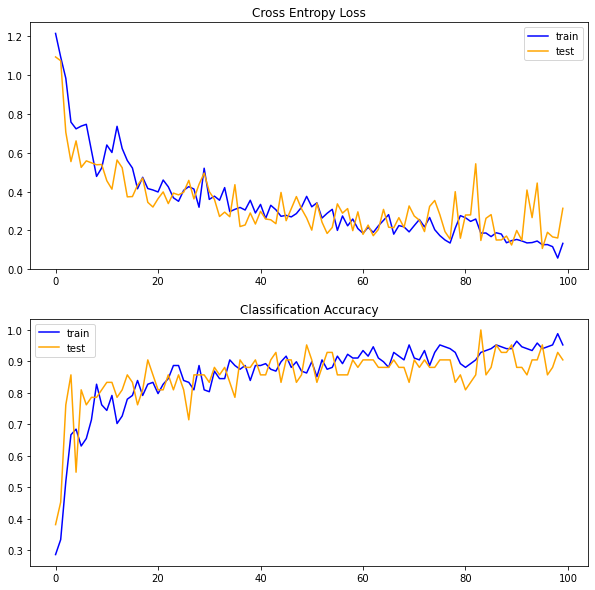

In [33]:
#Plotting History
fig, axs = plt.subplots(2,1,figsize=(10,10))
axs[0].title.set_text('Cross Entropy Loss')
axs[0].plot(history.history['loss'], color='blue', label='train')
axs[0].plot(history.history['val_loss'], color='orange', label='test')
axs[0].legend()
axs[1].title.set_text('Classification Accuracy')
axs[1].plot(history.history['accuracy'], color='blue', label='train')
axs[1].plot(history.history['val_accuracy'], color='orange', label='test')
axs[1].legend()

In [34]:
#Evaluate the model
acc = CNN.evaluate(validation_set,verbose=0)
print("Evaluate on test data")
print("Test Loss: {}, Test Acc: {}".format(acc[0],acc[1]))

  ...
    to  
  ['...']
Evaluate on test data
Test Loss: 0.2059233399728934, Test Acc: 0.9285714030265808


In [21]:
batch = next(pred_set)
pred = CNN.predict(batch)
pred = np.argmax(pred, axis=1)

In [19]:
ss = pd.read_csv('kaggle_sample.csv')
ss['class'] = 